In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
import warnings
warnings.filterwarnings('ignore')


In [ ]:
df = pd.read_csv('../data/churn-data.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# drop customerID 
df.drop('customerID', axis=1, inplace=True)

In [5]:
categorical_columns = df.select_dtypes(include=['category', 'object']).columns
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_data = one_hot_encoder.fit_transform(df[categorical_columns])
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=one_hot_encoder.get_feature_names_out(categorical_columns))
df.drop(columns=categorical_columns, inplace=True)
df.reset_index(drop=True, inplace=True)
df = pd.concat([df, encoded_categorical_df], axis=1)

In [6]:
df.drop('Churn_No', axis=1, inplace=True)
df.rename(columns={'Churn_Yes': 'Churn'}, inplace=True)

In [7]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
model_scores = []

models = {
    'Random Forest': (RandomForestClassifier(random_state=42), 
                      {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}),
    'Support Vector Machine': (SVC(random_state=42, class_weight='balanced'), 
                               {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    'Logistic Regression': (LogisticRegression(random_state=42, class_weight='balanced'), 
                            {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), 
                      {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}),
    'XG Boost': (XGBClassifier(random_state=42), 
                 {'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1, 0.5]}),
    'Naive Bayes': (GaussianNB(), {})
}

best_model = None
best_accuracy = 0.0

for name, (model, param_grid) in models.items():
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])

    if param_grid:
        grid_search = GridSearchCV(pipeline, {'model__' + k: v for k, v in param_grid.items()}, cv=2)
        grid_search.fit(X_train, y_train)
        pipeline = grid_search.best_estimator_

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=2)
    accuracy = cv_scores.mean()

    model_scores.append({'Model': name, 'Accuracy': accuracy})

    print(f"Evaluating Model: {name}")
    print(f"Average Cross-validated Accuracy: {accuracy:.4f}")
    print("-" * 40)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline

print("Best Model Identified:")
print(f"Model Name: {best_model.named_steps['model'].__class__.__name__}")
print(f"Cross-validated Accuracy: {best_accuracy:.4f}")
print(f"Model Pipeline Details: {best_model}")

Evaluating Model: Random Forest
Average Cross-validated Accuracy: 0.7988
----------------------------------------
Evaluating Model: Support Vector Machine
Average Cross-validated Accuracy: 0.7348
----------------------------------------
Evaluating Model: Logistic Regression
Average Cross-validated Accuracy: 0.7460
----------------------------------------
Evaluating Model: Decision Tree
Average Cross-validated Accuracy: 0.7543
----------------------------------------
Evaluating Model: XG Boost
Average Cross-validated Accuracy: 0.7995
----------------------------------------
Evaluating Model: Naive Bayes
Average Cross-validated Accuracy: 0.6937
----------------------------------------
Best Model Identified:
Model Name: XGBClassifier
Cross-validated Accuracy: 0.7995
Model Pipeline Details: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None,

### Data Augmentation

In [8]:
sm = SMOTEENN()
X_res, y_res = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2)

model_scores = []

models = {
    'Random Forest': (RandomForestClassifier(random_state=42), 
                      {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}),
    'Support Vector Machine': (SVC(random_state=42, class_weight='balanced'), 
                               {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    'Logistic Regression': (LogisticRegression(random_state=42, class_weight='balanced'), 
                            {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), 
                      {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}),
    'XG Boost': (XGBClassifier(random_state=42), 
                 {'max_depth': [3, 4, 5], 'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200, 300], 'subsample': [0.8, 0.9, 1.0]}),
    'Naive Bayes': (GaussianNB(), {})
}

best_model = None
best_accuracy = 0.0

results = []

for name, (model, param_grid) in models.items():
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])

    if param_grid:
        grid_search = GridSearchCV(pipeline, {"model__" + k: v for k, v in param_grid.items()}, cv=2, verbose=0)
        grid_search.fit(X_train, y_train)
        pipeline = grid_search.best_estimator_

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    accuracy = cv_scores.mean()
    cv_scores_std = cv_scores.std()
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    # accuracy = acc
    # uracy_score(y_test, y_pred)

    
    model_scores.append({'Model': name, 'Accuracy': accuracy, 'ROC_AUC': roc_auc_score(y_test, y_pred), 'Cross_Val_Accuracy': cv_scores.mean(), 'Stability': cv_scores.std(), "f1_score": f1_score(y_test, y_pred)})

    print(f"Evaluating Model: {name}")
    print(f"Average Cross-validated Accuracy: {accuracy:.4f}")
    print(f"Cross-validated Stability: {cv_scores_std:.4f}")
    print("-" * 40)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline

print("Best Model Identified:")
print(f"Model Name: {best_model.named_steps['model'].__class__.__name__}")
print(f"Cross-validated Accuracy: {best_accuracy:.4f}")
print(f"Model Pipeline Details: {best_model}")

Evaluating Model: Random Forest
Average Cross-validated Accuracy: 0.9537
Cross-validated Stability: 0.0049
----------------------------------------
Evaluating Model: Support Vector Machine
Average Cross-validated Accuracy: 0.9401
Cross-validated Stability: 0.0064
----------------------------------------
Evaluating Model: Logistic Regression
Average Cross-validated Accuracy: 0.9171
Cross-validated Stability: 0.0046
----------------------------------------
Evaluating Model: Decision Tree
Average Cross-validated Accuracy: 0.9399
Cross-validated Stability: 0.0059
----------------------------------------
Evaluating Model: XG Boost
Average Cross-validated Accuracy: 0.9565
Cross-validated Stability: 0.0050
----------------------------------------
Evaluating Model: Naive Bayes
Average Cross-validated Accuracy: 0.8877
Cross-validated Stability: 0.0055
----------------------------------------
Best Model Identified:
Model Name: XGBClassifier
Cross-validated Accuracy: 0.9565
Model Pipeline Details

5-Fold Cross-Validation Results:
Mean Accuracy: 0.956
Standard Deviation: 0.005


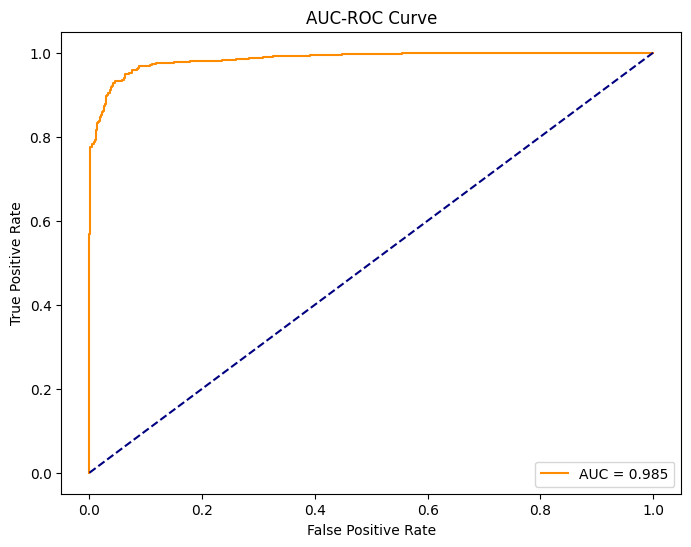

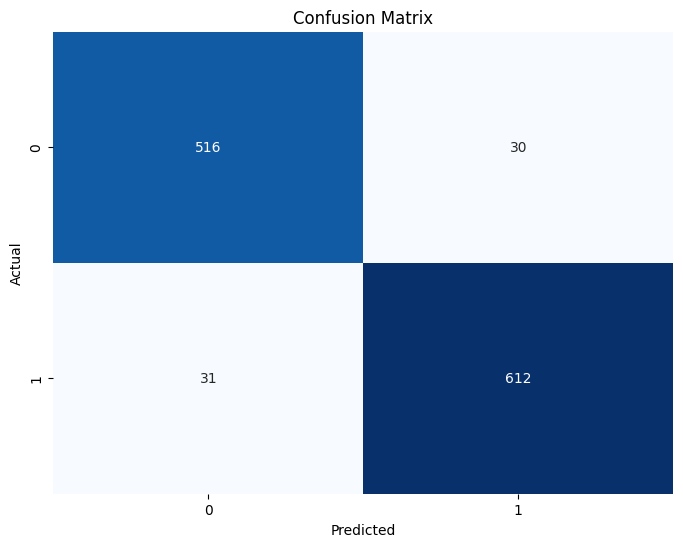

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       546
         1.0       0.95      0.95      0.95       643

    accuracy                           0.95      1189
   macro avg       0.95      0.95      0.95      1189
weighted avg       0.95      0.95      0.95      1189



TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [9]:
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap

# 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')

print("5-Fold Cross-Validation Results:")
print(f"Mean Accuracy: {np.mean(cv_scores):.3f}")
print(f"Standard Deviation: {np.std(cv_scores):.3f}")

# AUC-ROC Curve
if hasattr(best_model, "predict_proba"):
    y_pred_proba = cross_val_predict(best_model, X_test, y_test, cv=cv, method="predict_proba")[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color="darkorange")
    plt.plot([0, 1], [0, 1], linestyle="--", color="navy")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUC-ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix
y_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))



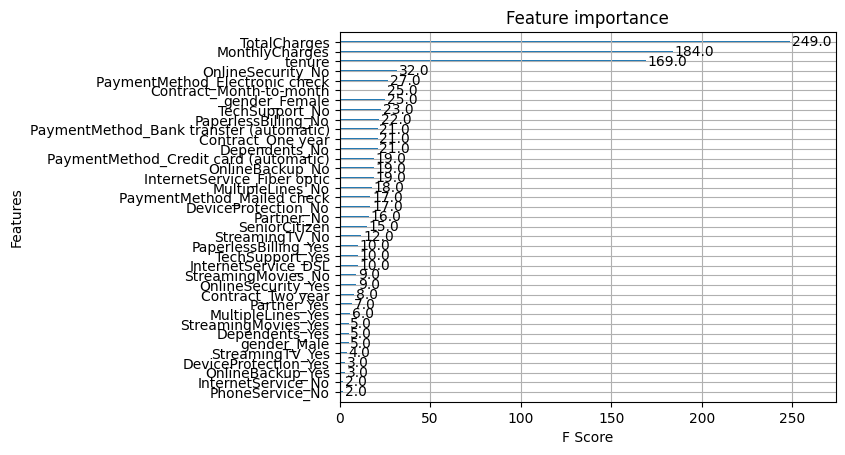

In [17]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

feature_names = X.columns.tolist()

xgb_model = best_model.named_steps['model']
xgb_model.get_booster().feature_names = feature_names

plot_importance(xgb_model, max_num_features=45, importance_type='weight', xlabel='F Score')
plt.show()


<Figure size 1600x1200 with 0 Axes>

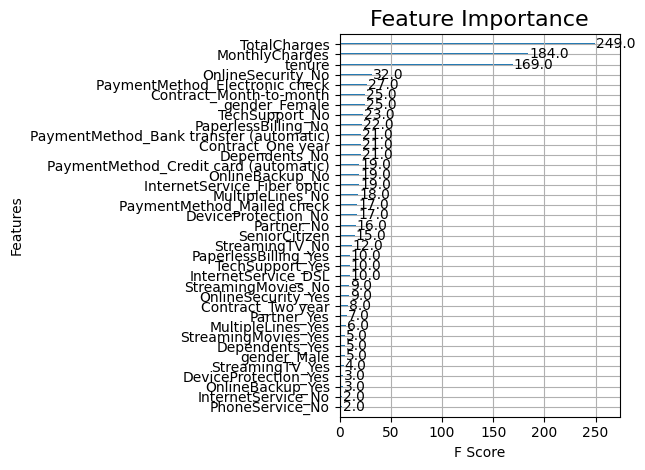

In [21]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

feature_names = X.columns.tolist()
xgb_model = best_model.named_steps['model']

plt.figure(figsize=(16, 12))  # Larger figure for better readability
ax = plot_importance(xgb_model, max_num_features=45, importance_type='weight', xlabel='F Score')

ax.set_yticklabels(ax.get_yticklabels(), fontsize=10, rotation=0, ha='right')

plt.title("Feature Importance", fontsize=16)

plt.tight_layout()  # Automatically adjust subplot parameters to give padding
plt.show()


In [15]:
feature_names = X.columns.tolist()
len(feature_names)

45

In [9]:
class NeuralNetworkClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, **kwargs):
        self.build_fn = build_fn
        self.kwargs = kwargs
        self.model = None

    def fit(self, X, y):
        self.model = self.build_fn(**self.kwargs)
        self.model.fit(X, y, epochs=1000, batch_size=64, verbose=0)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def score(self, X, y):
        return self.model.evaluate(X, y, verbose=0)[1]

def build_model():
    inputs = tf.keras.Input(shape=(45,), name="input_layer")
    x = Dense(32, activation='relu', name='dense')(inputs)
    x = Dropout(0.5, name='dropout')(x)
    x = Dense(16, activation='relu', name='dense_1')(x)
    x = Dropout(0.5, name='dropout_1')(x)
    outputs = Dense(1, activation='sigmoid', name='dense_2')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

ann_clf = NeuralNetworkClassifier(build_fn=build_model)

cv_scores = cross_val_score(ann_clf, X_res, y_res, cv=5)

model_scores.append({
    'Model': 'Neural Network',
    'Accuracy': accuracy,
    'ROC_AUC': roc_auc_score(y_test, y_pred),
    'Cross_Val_Accuracy': cv_scores.mean(),
    'Stability': cv_scores.std(),
    "f1_score": f1_score(y_test, y_pred)
})

In [10]:
pd.DataFrame(model_scores).sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,ROC_AUC,Cross_Val_Accuracy,Stability,f1_score
4,XG Boost,0.959258,0.965400,0.959258,0.005020,0.968037
0,Random Forest,0.956698,0.968175,0.956698,0.007284,0.971212
1,Support Vector Machine,0.941769,0.940972,0.941769,0.008793,0.948872
3,Decision Tree,0.940058,0.937677,0.940058,0.007104,0.944739
2,Logistic Regression,0.922568,0.919277,0.922568,0.007224,0.927757
5,Naive Bayes,0.889505,0.884828,0.889505,0.005580,0.903704
6,Neural Network,0.889505,0.884828,0.916737,0.011031,0.903704


### Strategies to Reduce Customer Churn and Increase Revenue


#### 1. **Focus on Key Customer Groups**  
   - **Senior Citizens**: Premium-oriented customers who value high-quality, tailored services.  
   - **Those Living with a Partner**: Likely to value family-friendly services.  
   - **Individuals Living Alone**: May prefer personalized, independent service options.



### **Strategic Initiatives**

#### 2. **Senior Citizen Strategy**  
   - **Premium Services**: Offer high-quality, specialized plans for Senior Citizens.  
   - **Tailored Solutions**: Focus on convenience, security, and reliability, ensuring a superior customer experience.

#### 3. **Affordable Entry-Level Services**  
   - **First 6 Months Focus**: Provide affordable introductory packages.  
   - **Key Services**: Prioritize OnlineSecurity, OnlineBackup, DeviceProtection, and TechSupport to build trust and a strong foundation.

#### 4. **Optimized Streaming Services**  
   - **Affordability**: Make StreamingTV and StreamingMovies budget-friendly across all customer segments.  
   - **Diverse Content**: Cater to varied preferences with an extensive content library.  
   - **Simplified Payments**: Streamline the payment process for convenience.

#### 5. **Improved Payment Options**  
   - **Eliminate Electronic Check**: Discontinue this option due to high churn rates.  
   - **Preferred Methods**: Emphasize Bank Transfer (automatic) and Credit Card (automatic) payments.  
   - **Churn Tenure Focus**: Work on reducing churn rates for these preferred methods.

#### 6. **Paperless Billing Alternatives**  
   - **Cost Control**: Start with a baseline MonthlyCharge of $60 for PaperlessBilling.  
   - **More Affordable Options**: Explore alternatives starting at $20 to appeal to cost-sensitive customers.

#### 7. **Addressing Cost Sensitivity at 70**  
   - **Threshold Awareness**: Customers show sensitivity when single-service charges reach $70.  
   - **Service Quality Focus**: Highlight superior service quality as a key differentiator to retain customers at this price point.
